# CL2022 - DEVWKS-1391 - Build your first Machine Learning model with your Wi-Fi network data - Location Example

by Flavio Correa - @correaflavio

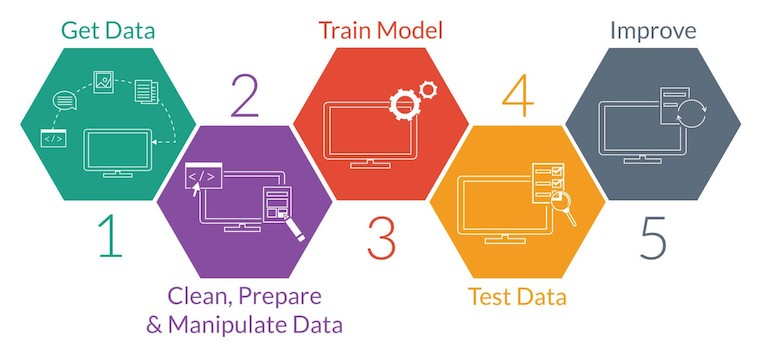

Image Source: https://towardsdatascience.com/wtf-is-machine-learning-a-quick-guide-39457e49c65b



---



---



# **0. Define what is your problem and how machine learning can help you.**

One of the most important things in Machine Learning is how you frame your problem, considering the capabilities of the different machine learning algorithms. Knowing what Machine Learning can and cannot do is critical.

One valid initial approach is to identify if your problem can be solved by a suppervised learning (in case you have or can generate data with labels for training and testing) or if you will have to use unsupervised learning (no labels available so you can for instance try to group your data depending of their characteristics).

### **Supervised Learning**


For each input in the training data set, there will be an known output associated.

- **Classification**: assign groups to input data based on previous data

- **Regression**: predicts real values based on previous data

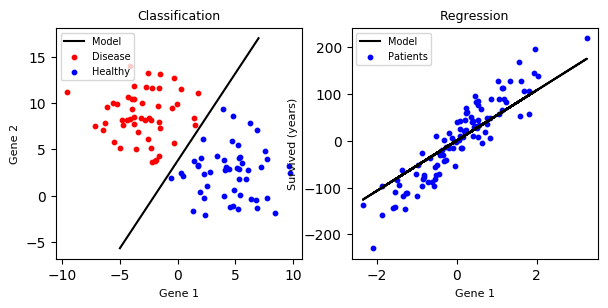

Image Source: https://dev.to/petercour/machine-learning-classification-vs-regression-1gn

### **Features and Labels**

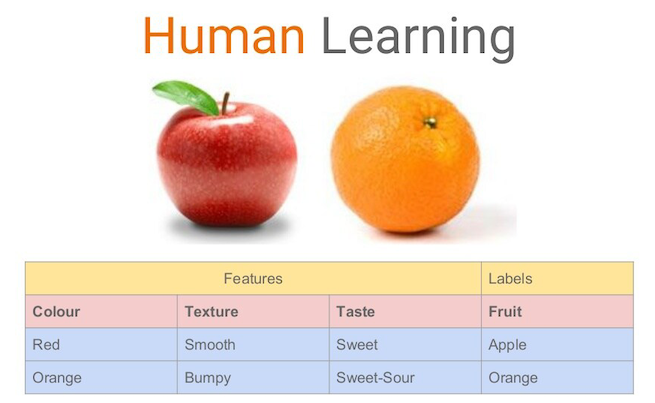

Image source: https://www.slideshare.net/lakshya90/machine-learning-workshop-84176551

### These are the main python packages that we will use.

- **Pandas** - #pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.
- **Numpy** - NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more. 
- **Matplotlib** - Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.
- **Sklearn** - Simple and efficient tools for predictive data analysis. Accessible to everybody, and reusable in various contexts. #Built on NumPy, SciPy, and matplotlib · Open.
- **Graphviz** - This package facilitates the creation and rendering of graph descriptions in the DOT language of the Graphviz graph drawing software from Python.

In [2]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

### **Supervised Learning Classification Example - Location Data**

Let's run a first basic example that is about creating a Machine Learning model that can **predict the location**, of a device based in previous examples observed. 
<br><br>

First need to think about what will be the characteristics that you will use to evaluate the location of the device. These are called features.<br><br>

Second we will need to capture data with examples of the different locations that we want to predict. For each example we will collect the features and the label for that example. 

The **features will be the RSSI levels** registered for that client. The **labels will identify the areas or rooms** in our location calculation problem. 
<br><br>


Framing the problem this way we are making the location prediction a classification task. The other approach to this problem is to calculate the x/y position of the device and this will make the location prediction problem a regression problem.
<br><br>

In this workshop we will work on it as a **classification example**.



The location information that we will use is the point where the data was collected (p1 - position 1).

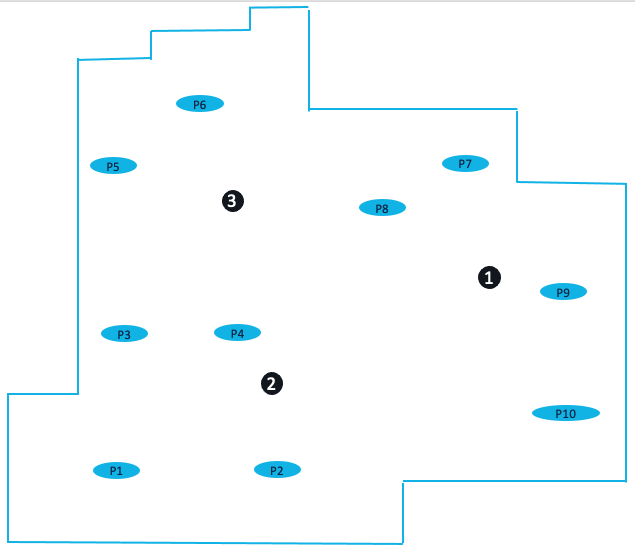

The objective is to build a table like this with the readings, to be used to build our ML model.

In [1]:
import pandas as pd

d = {'AP1': ['-69', '-76','-70' ], 'AP2': ['-81', '-78','-85'], 'AP3': ['-68', '-59','-76'], 'location': ['p1', 'p2', 'p3']}
d_df = pd.DataFrame(data=d)
d_df

,AP1,AP2,AP3,location
0,-69,-81,-68,p1
1,-76,-78,-59,p2
2,-70,-85,-76,p3




---



# **1. Getting data to train your model**

### First you need is data. Sources of data for Wi-Fi related scenarios

- **Wireless LAN Controller Telemetry** - APs, clients, mobility, rrm, rogue, etc.
- **Location Services data** - number of visitors, devices, time of visit, number of visits, raw x/y data, etc. 
- **Wi-Fi and BLE IoT data** - temperature, pressure, humidity, CO2 level, PiR presence, etc.

### How to capture client RSSI data







First you need to **capture client rssi data** from your network. These will be your examples to train the model.

There are different ways of doing that and this task is sometimes called fingerprinting or in the past we've done something similar as part of the callibration of the location models (do you remember that? ;-/)

You are probably thinking why should I build my own "location engine" if there are multiple ones available in the market? 

First because it's cool and it's an interesting example to start your understanding of machine learning with a real problem and data from your Wi-Fi Network.

Second, the beauty of making your own location model is that you could potentially extend this model to use other sources of data. So you can start with Wi-Fi RSSI but you could mix BLE RSSI, ultrasound based proximity data and other sources like images and so on.

- Meraki networks can now stream real time **RSSI information from Access Points based on MQTT**. This is great because its very realtime and it's send directly by your Access Points to the Cloud. Detailed information about how to setup and collect data is presented here in this documentation: https://documentation.meraki.com/MR/Other_Topics/MR_MQTT_Data_Streaming

- Catalyst Wireless LAN controllers don't send raw RSSI data, nor Cisco DNA Spaces provides this data. All the data provided is already processed. One approach with Cisco DNA Spaces data for this problem is to collect the location information from DNA Spaces and mix is with other location data for instance based on BLE or images. It will look like more as a location data fusion problem that we could use machine learning to help.

- Another approach is to collect data using a cellphone and use that to build the model. This is another approach but you will after have to run the model on the phone to make predictions. I.e. Android Wifi Fingerprinting APP and BLE scanner.

### Getting Meraki MR using MQTT.


The procedure used to collect that was to position different smartphones in different positions and registre the RSSI data that the Access Points in that region were listing to that client. So it's a receive RSSI (dBm) level for each client registered by each AP.

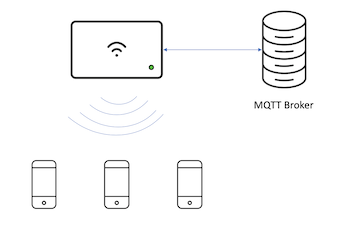

In my setup I've published my APs RSSI data to the free MQTT broker broker.hivemq.com. And to collect the data I've subscribed to my topic and used a python client called paho mqtt client.
<br><br>

MQTT Broker: https://www.hivemq.com/public-mqtt-broker/
<br><br>

Paho - python MQTT client: https://www.eclipse.org/paho/index.php?page=clients/python/index.php

This is an example of the data that you get when subscribed to the MQTT topic for one MR:

In [4]:
mr_mqtt_data = {'mrMac': '98:18:88:13:10:9D', 
                'clientType': 'visible', 
                'clientMac': '3E:28:CF:72:95:3A', 
                'timestamp': '2022-05-17 02:00:16.693', 
                'rssi': '-63', 
                'radio': 'wifi'}

If you keep listening to the data, you will get multiple entries like that.

This data can be easily accessed using the python dictionary keys and value pairs.

In [5]:
mr_mqtt_data['clientMac']

'3E:28:CF:72:95:3A'

In [7]:
mr_mqtt_data['rssi']

'-63'

# **2. Cleaning, manipulating and preparing the data**

### Parsing the data from MQTT broker to python dictionary to a Pandas dataframe & Selecting the features

Convert the data that comes from MQTT broker in python dictionaries and finally to a pandas dataframe that will be used to easily manipulate the data later.

Each column is a feature that we can potentially use to classify where the device is located. 

We can also add more data from different sources like BLE. 

**This is where the SME (you) can make a difference.**

In [8]:
mr_mqtt_entries = []

In [9]:
mr_mqtt_1 = {'mrMac': '98:18:88:13:10:9D', 'clientType': 'visible', 'clientMac': '3E:28:CF:72:95:3A', 'timestamp': '2022-05-17 01:48:42.956', 'rssi': '-51', 'radio': 'wifi'}
mr_mqtt_2 = {'mrMac': 'E0:CB:BC:34:7E:0D', 'clientType': 'visible', 'clientMac': '3E:28:CF:72:95:3A', 'timestamp': '2022-05-17 01:48:18.676', 'status': 'offline', 'rssi': '-83', 'radio': 'wifi'}
mr_mqtt_3 ={'mrMac': 'F8:9E:28:73:AF:32', 'clientType': 'visible', 'clientMac': '3E:28:CF:72:95:3A', 'timestamp': '2022-05-17 01:48:23.957', 'status': 'offline', 'rssi': '-79', 'radio': 'wifi'}

In [10]:
type(mr_mqtt_1)

dict

In [11]:
mr_mqtt_entries = [mr_mqtt_1, mr_mqtt_2, mr_mqtt_3]

In [12]:
mr_mqtt_entries

[{'mrMac': '98:18:88:13:10:9D',
  'clientType': 'visible',
  'clientMac': '3E:28:CF:72:95:3A',
  'timestamp': '2022-05-17 01:48:42.956',
  'rssi': '-51',
  'radio': 'wifi'},
 {'mrMac': 'E0:CB:BC:34:7E:0D',
  'clientType': 'visible',
  'clientMac': '3E:28:CF:72:95:3A',
  'timestamp': '2022-05-17 01:48:18.676',
  'status': 'offline',
  'rssi': '-83',
  'radio': 'wifi'},
 {'mrMac': 'F8:9E:28:73:AF:32',
  'clientType': 'visible',
  'clientMac': '3E:28:CF:72:95:3A',
  'timestamp': '2022-05-17 01:48:23.957',
  'status': 'offline',
  'rssi': '-79',
  'radio': 'wifi'}]

In [13]:
#Importing the list of dictionaries into a Pandas dataframe
import pandas as pd

df = pd.DataFrame(mr_mqtt_entries)

In [14]:
#Let visualize the dataframe created
df

,mrMac,clientType,clientMac,timestamp,rssi,radio,status
0,98:18:88:13:10:9D,visible,3E:28:CF:72:95:3A,2022-05-17 01:48:42.956,-51,wifi,NaN
1,E0:CB:BC:34:7E:0D,visible,3E:28:CF:72:95:3A,2022-05-17 01:48:18.676,-83,wifi,offline
2,F8:9E:28:73:AF:32,visible,3E:28:CF:72:95:3A,2022-05-17 01:48:23.957,-79,wifi,offline


### Labeling the data

We also need to **add labels to the data**, saying in which location that example was collected / recorded.

Here we are using the Supervised Learning scenario.

In [15]:
#Add a new column in the dataframe called location with the value "Area A"
df['location'] = "p1"

In [16]:
df

,mrMac,clientType,clientMac,timestamp,rssi,radio,status,location
0,98:18:88:13:10:9D,visible,3E:28:CF:72:95:3A,2022-05-17 01:48:42.956,-51,wifi,NaN,p1
1,E0:CB:BC:34:7E:0D,visible,3E:28:CF:72:95:3A,2022-05-17 01:48:18.676,-83,wifi,offline,p1
2,F8:9E:28:73:AF:32,visible,3E:28:CF:72:95:3A,2022-05-17 01:48:23.957,-79,wifi,offline,p1



### Building the final dataset

Since it's our first example and the data that is available, let's use just the AP mac, client mac, timestamp and rssi levels registered by each AP and remove the others.

In [17]:
df = df.drop(columns=['clientType','radio', 'status'])
df

,mrMac,clientMac,timestamp,rssi,location
0,98:18:88:13:10:9D,3E:28:CF:72:95:3A,2022-05-17 01:48:42.956,-51,p1
1,E0:CB:BC:34:7E:0D,3E:28:CF:72:95:3A,2022-05-17 01:48:18.676,-83,p1
2,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,2022-05-17 01:48:23.957,-79,p1


As you've could noticed, the MQTT data is generated per AP and with that we have separate observations for the same client per AP.

In the other hand we want to have examples showing the different rssi levels for the same client registered by different APs in a time instant as one single entry. 

The objetive is to use the "triangulation" idea.

For that we will use the timestamp to aggregate the measurements.

First let's load all the json that we collected in the different points of measurements.

In [18]:
#Let's delete this example df and load the final df
del df

In [19]:
#Loading all the files from the mqtt data directory
data_dir = 'data/'

In [20]:
import json
import ast
import os

df_list = []

for filename in os.listdir(data_dir):
  file_path = data_dir + filename
  print(file_path)
  
  with open(file_path) as file:
      
      mqtt_entry = {}
      mqtt_entry_list = []
      lines = []
      
      for line in file:
        mqtt_entry = ast.literal_eval(line) #convert the line which is a string to python dictionary
        mqtt_entry_list.append(mqtt_entry) #build a list of dictionaries
      
      mqtt_df = pd.DataFrame(data=mqtt_entry_list) #create a pandas dataframes based on the list of dictionaries
      
      mqtt_df['location'] = str(filename.split("_")[0]) # add the location label based on the name of the file

      df_list.append(mqtt_df)      
      

df = pd.concat(df_list, ignore_index=True)

df

data/p2_ap_mqtt.log
data/p7_ap_mqtt.log
data/p4_ap_mqtt.log
data/p1_ap_mqtt.log
data/p8_ap_mqtt.log
data/p10_ap_mqtt.log
data/p6_ap_mqtt.log
data/p3_ap_mqtt.log
data/p9_ap_mqtt.log
data/p5_ap_mqtt.log


,mrMac,clientType,clientMac,timestamp,rssi,radio,status,location
0,F8:9E:28:73:AF:32,visible,3E:28:CF:72:95:3A,2022-05-17 01:06:20.632,-69,wifi,NaN,p2
1,F8:9E:28:73:AF:32,visible,3E:28:CF:72:95:3A,2022-05-17 01:06:30.52,-70,wifi,NaN,p2
2,E0:CB:BC:34:7E:0D,visible,3E:28:CF:72:95:3A,2022-05-17 01:06:32.213,-76,wifi,NaN,p2
3,F8:9E:28:73:AF:32,visible,3E:28:CF:72:95:3A,2022-05-17 01:06:32.221,-60,wifi,NaN,p2
4,F8:9E:28:73:AF:32,visible,3E:28:CF:72:95:3A,2022-05-17 01:06:32.101,-70,wifi,NaN,p2
...,...,...,...,...,...,...,...,...
711,E0:CB:BC:34:7E:0D,visible,2E:BE:5A:CE:E1:F2,2022-05-17 01:28:19.727,-64,wifi,NaN,p5
712,E0:CB:BC:34:7E:0D,visible,2E:BE:5A:CE:E1:F2,2022-05-17 01:28:43.178,-68,wifi,NaN,p5
713,F8:9E:28:73:AF:32,visible,2E:BE:5A:CE:E1:F2,2022-05-17 01:28:19.770,-71,wifi,offline,p5
714,E0:CB:BC:34:7E:0D,visible,3E:28:CF:72:95:3A,2022-05-17 01:28:54.584,-71,wifi,NaN,p5


In [21]:
#Remove data that we are not interested
df = df.drop(columns=['clientType','radio', 'status'])
df

,mrMac,clientMac,timestamp,rssi,location
0,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,2022-05-17 01:06:20.632,-69,p2
1,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,2022-05-17 01:06:30.52,-70,p2
2,E0:CB:BC:34:7E:0D,3E:28:CF:72:95:3A,2022-05-17 01:06:32.213,-76,p2
3,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,2022-05-17 01:06:32.221,-60,p2
4,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,2022-05-17 01:06:32.101,-70,p2
...,...,...,...,...,...
711,E0:CB:BC:34:7E:0D,2E:BE:5A:CE:E1:F2,2022-05-17 01:28:19.727,-64,p5
712,E0:CB:BC:34:7E:0D,2E:BE:5A:CE:E1:F2,2022-05-17 01:28:43.178,-68,p5
713,F8:9E:28:73:AF:32,2E:BE:5A:CE:E1:F2,2022-05-17 01:28:19.770,-71,p5
714,E0:CB:BC:34:7E:0D,3E:28:CF:72:95:3A,2022-05-17 01:28:54.584,-71,p5


In [22]:
# Create a new column with simplified time. Minute resolution
from datetime import datetime

time = []

for value in df["timestamp"]:
  #print(value)
  date_time_obj = datetime.fromisoformat(value.split(".")[0][:-3]) #split to remove microseconds and slice to keep up to minute
  time.append(date_time_obj)
       
df["time"] = time

df = df.drop(columns=['timestamp'])

df

,mrMac,clientMac,rssi,location,time
0,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-69,p2,2022-05-17 01:06:00
1,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-70,p2,2022-05-17 01:06:00
2,E0:CB:BC:34:7E:0D,3E:28:CF:72:95:3A,-76,p2,2022-05-17 01:06:00
3,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-60,p2,2022-05-17 01:06:00
4,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-70,p2,2022-05-17 01:06:00
...,...,...,...,...,...
711,E0:CB:BC:34:7E:0D,2E:BE:5A:CE:E1:F2,-64,p5,2022-05-17 01:28:00
712,E0:CB:BC:34:7E:0D,2E:BE:5A:CE:E1:F2,-68,p5,2022-05-17 01:28:00
713,F8:9E:28:73:AF:32,2E:BE:5A:CE:E1:F2,-71,p5,2022-05-17 01:28:00
714,E0:CB:BC:34:7E:0D,3E:28:CF:72:95:3A,-71,p5,2022-05-17 01:28:00


In [23]:
#Lets slice the data for one location
df1 = df.query("location == 'p1'")
df1 #dataframe with all the location records for p1"

,mrMac,clientMac,rssi,location,time
228,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-67,p1,2022-05-17 00:59:00
229,E0:CB:BC:34:7E:0D,3E:28:CF:72:95:3A,-81,p1,2022-05-17 00:59:00
230,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-68,p1,2022-05-17 00:59:00
231,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-61,p1,2022-05-17 01:00:00
232,98:18:88:13:10:9D,2E:BE:5A:CE:E1:F2,-76,p1,2022-05-17 00:59:00
...,...,...,...,...,...
287,F8:9E:28:73:AF:32,2E:BE:5A:CE:E1:F2,-64,p1,2022-05-17 01:03:00
288,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-70,p1,2022-05-17 01:04:00
289,E0:CB:BC:34:7E:0D,3E:28:CF:72:95:3A,-86,p1,2022-05-17 01:04:00
290,F8:9E:28:73:AF:32,2E:BE:5A:CE:E1:F2,-58,p1,2022-05-17 01:04:00


In [24]:
#If we look at the time slots available for this specific location we have...
df1.time.unique()

array(['2022-05-17T00:59:00.000000000', '2022-05-17T01:00:00.000000000',
       '2022-05-17T01:01:00.000000000', '2022-05-17T01:02:00.000000000',
       '2022-05-17T01:03:00.000000000', '2022-05-17T01:04:00.000000000'],
      dtype='datetime64[ns]')

In [25]:
#If we slice the data again for just a single time frame for this location
df1_time = df1.loc[df1['time'] == df1.time.unique()[0]]
df1_time.head(15)

,mrMac,clientMac,rssi,location,time
228,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-67,p1,2022-05-17 00:59:00
229,E0:CB:BC:34:7E:0D,3E:28:CF:72:95:3A,-81,p1,2022-05-17 00:59:00
230,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-68,p1,2022-05-17 00:59:00
232,98:18:88:13:10:9D,2E:BE:5A:CE:E1:F2,-76,p1,2022-05-17 00:59:00
234,98:18:88:13:10:9D,3E:28:CF:72:95:3A,-69,p1,2022-05-17 00:59:00
235,F8:9E:28:73:AF:32,2E:BE:5A:CE:E1:F2,-59,p1,2022-05-17 00:59:00
236,E0:CB:BC:34:7E:0D,2E:BE:5A:CE:E1:F2,-78,p1,2022-05-17 00:59:00
238,E0:CB:BC:34:7E:0D,3E:28:CF:72:95:3A,-81,p1,2022-05-17 00:59:00


In [26]:
#If we look at the unique clients ...
df1_time.clientMac.unique()

array(['3E:28:CF:72:95:3A', '2E:BE:5A:CE:E1:F2'], dtype=object)

In [27]:
#Now lets slice it again for just one client Mac Address
df1_client = df1_time.loc[df1_time['clientMac'] == df1_time.clientMac.unique()[0]]
df1_client

,mrMac,clientMac,rssi,location,time
228,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-67,p1,2022-05-17 00:59:00
229,E0:CB:BC:34:7E:0D,3E:28:CF:72:95:3A,-81,p1,2022-05-17 00:59:00
230,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-68,p1,2022-05-17 00:59:00
234,98:18:88:13:10:9D,3E:28:CF:72:95:3A,-69,p1,2022-05-17 00:59:00
238,E0:CB:BC:34:7E:0D,3E:28:CF:72:95:3A,-81,p1,2022-05-17 00:59:00


In [28]:
# In cases were we had more than one measurement for that client in a single minute
# we need to consolidate the data. 
#Let's use the last measurement.
df1_client = df1_client.drop_duplicates(subset = ['mrMac', 'time'], keep = 'last').reset_index(drop = True)
df1_client

,mrMac,clientMac,rssi,location,time
0,F8:9E:28:73:AF:32,3E:28:CF:72:95:3A,-68,p1,2022-05-17 00:59:00
1,98:18:88:13:10:9D,3E:28:CF:72:95:3A,-69,p1,2022-05-17 00:59:00
2,E0:CB:BC:34:7E:0D,3E:28:CF:72:95:3A,-81,p1,2022-05-17 00:59:00


In [29]:
# With the data selected we can construct a new dataframe with a single entry
# per client in a certain timeslot in a certain location
df1_rssi = df1_client.pivot(index='time', columns='mrMac', values='rssi')
df1_rssi

mrMac,98:18:88:13:10:9D,E0:CB:BC:34:7E:0D,F8:9E:28:73:AF:32
time,,,
2022-05-17 00:59:00,-69,-81,-68


In [30]:
#Original Dataframe shape before transformation
df.shape

(716, 5)

In [31]:
#Function that does all the steps described above to transform the data
#df_new = pd.Dataframe
def df_transform_single_location(df):
  new_df = pd.DataFrame()

  for location in df.location.unique():

    for time in df.time.unique():
      #Slice the data minute by minute of the recordings
      df_time = (df.loc[df['time'] == time])

      for client_mac in df_time.clientMac.unique():        
        #Slice again the by minute data, now per client
        df_client = df_time.loc[df_time['clientMac'] == client_mac]

        #Remove the duplicate entries, keeping only the last registred in that minute
        df_client = df_client.drop_duplicates(subset = ['mrMac', 'time'], keep = 'last').reset_index(drop = True)

        #Transform the data from 3 lines (one per AP) to a single line for each client in that minute
        df_rssi = df_client.pivot(index='time', columns='mrMac', values='rssi')

        #Append the data transformed in a final new daraframe
        new_df = new_df.append(df_rssi)
          
  return new_df

In [32]:
#Since we want to apply it to all the locations and build a final dataframe,
#with location column back on, lets loop over the data and add the location
#column again.

import warnings
warnings.filterwarnings('ignore')

df_final = pd.DataFrame()

for loc in df.location.unique():
  print(loc)
  df_loc = df.loc[df['location'] == loc]
  df_transform = df_transform_single_location(df_loc)
  df_transform['location'] = loc
  df_final = df_final.append(df_transform)

p2
p7
p4
p1
p8
p10
p6
p3
p9
p5


In [33]:
#New df shape
df_final.shape

(91, 4)

In [34]:
df_final

mrMac,E0:CB:BC:34:7E:0D,F8:9E:28:73:AF:32,location,98:18:88:13:10:9D
time,,,,
2022-05-17 01:06:00,-73,-66,p2,NaN
2022-05-17 01:06:00,-72,-62,p2,NaN
2022-05-17 01:07:00,-75,-64,p2,NaN
2022-05-17 01:07:00,NaN,-61,p2,NaN
2022-05-17 01:08:00,-78,-65,p2,NaN
...,...,...,...,...
2022-05-17 01:26:00,-65,-66,p5,NaN
2022-05-17 01:27:00,-66,NaN,p5,NaN
2022-05-17 01:27:00,-56,-75,p5,NaN


In [35]:
#In certain locations not all APs listened to the client (NaN values)
#For these we need to input a value to be able to use in our machine learning models
#SME can decide and play with it, but -100 for me can represent this situation

df_final = df_final.fillna("-100")
df_final

mrMac,E0:CB:BC:34:7E:0D,F8:9E:28:73:AF:32,location,98:18:88:13:10:9D
time,,,,
2022-05-17 01:06:00,-73,-66,p2,-100
2022-05-17 01:06:00,-72,-62,p2,-100
2022-05-17 01:07:00,-75,-64,p2,-100
2022-05-17 01:07:00,-100,-61,p2,-100
2022-05-17 01:08:00,-78,-65,p2,-100
...,...,...,...,...
2022-05-17 01:26:00,-65,-66,p5,-100
2022-05-17 01:27:00,-66,-100,p5,-100
2022-05-17 01:27:00,-56,-75,p5,-100


In [36]:
#Now let's rename the columns from the AP mac to the AP name
df_final = df_final.rename(columns={"98:18:88:13:10:9D": "AP1", "F8:9E:28:73:AF:32": 'AP2', "E0:CB:BC:34:7E:0D": "AP3"})
df_final

mrMac,AP3,AP2,location,AP1
time,,,,
2022-05-17 01:06:00,-73,-66,p2,-100
2022-05-17 01:06:00,-72,-62,p2,-100
2022-05-17 01:07:00,-75,-64,p2,-100
2022-05-17 01:07:00,-100,-61,p2,-100
2022-05-17 01:08:00,-78,-65,p2,-100
...,...,...,...,...
2022-05-17 01:26:00,-65,-66,p5,-100
2022-05-17 01:27:00,-66,-100,p5,-100
2022-05-17 01:27:00,-56,-75,p5,-100


The location information that we were using so far is the point where the data was collected (p1 - position 1). <br><br>

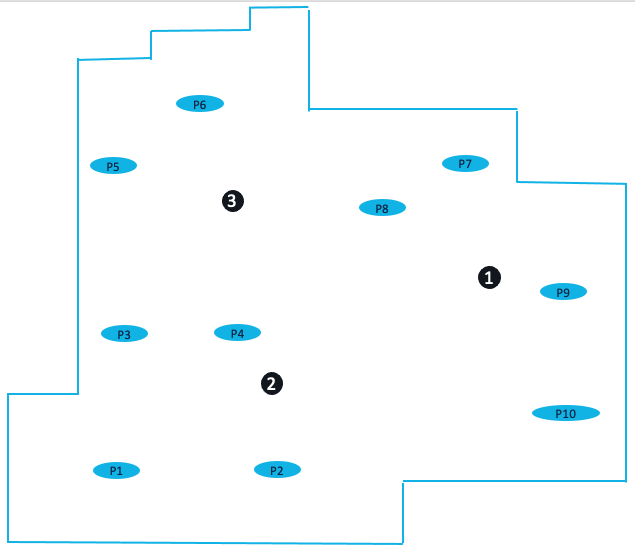

Since we will run a first model to understand if the client is at the west or east side of the building, we will add a new column that represents the zone of the measurement. This column will be our label or class. <br><br>

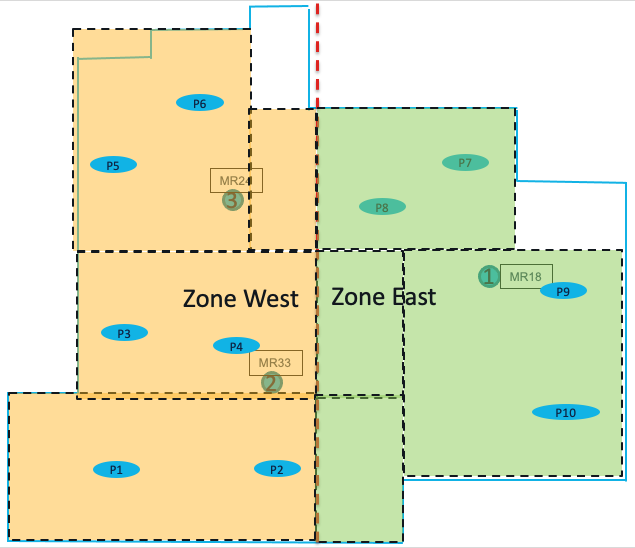

In [37]:
#Add a new column called Zone based on the positions
df_final.loc[df_final['location']=='p1','Zone'] = 'West'
df_final.loc[df_final['location']=='p2','Zone'] = 'West'
df_final.loc[df_final['location']=='p3','Zone'] = 'West'
df_final.loc[df_final['location']=='p4','Zone'] = 'West'
df_final.loc[df_final['location']=='p5','Zone'] = 'West'
df_final.loc[df_final['location']=='p6','Zone'] = 'West'
df_final.loc[df_final['location']=='p7','Zone'] = 'East'
df_final.loc[df_final['location']=='p8','Zone'] = 'East'
df_final.loc[df_final['location']=='p9','Zone'] = 'East'
df_final.loc[df_final['location']=='p10','Zone'] = 'East'

In [38]:
df_final

mrMac,AP3,AP2,location,AP1,Zone
time,,,,,
2022-05-17 01:06:00,-73,-66,p2,-100,West
2022-05-17 01:06:00,-72,-62,p2,-100,West
2022-05-17 01:07:00,-75,-64,p2,-100,West
2022-05-17 01:07:00,-100,-61,p2,-100,West
2022-05-17 01:08:00,-78,-65,p2,-100,West
...,...,...,...,...,...
2022-05-17 01:26:00,-65,-66,p5,-100,West
2022-05-17 01:27:00,-66,-100,p5,-100,West
2022-05-17 01:27:00,-56,-75,p5,-100,West


Now we can think about creating our first machine learning model with this data.

### Features distribution & data exploration

In [39]:
#Looking at the dataframe built.
df_final.describe()

mrMac,AP3,AP2,location,AP1,Zone
count,91,91,91,91,91
unique,28,33,10,32,2
top,-100,-100,p1,-100,West
freq,31,26,12,44,53


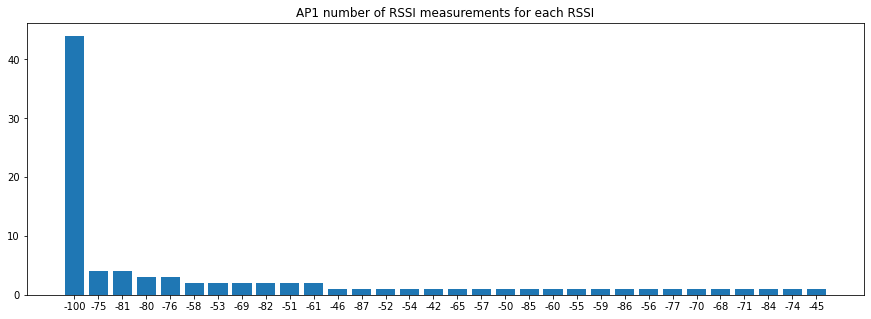

In [40]:
#Lets take a look at the measurement distribution
import matplotlib.pyplot as plt

counts = df_final['AP1'].value_counts()
plt.figure(figsize=(15,5))
plt.bar(counts.index, counts.values)
plt.title("AP1 number of RSSI measurements for each RSSI") 
plt.show()

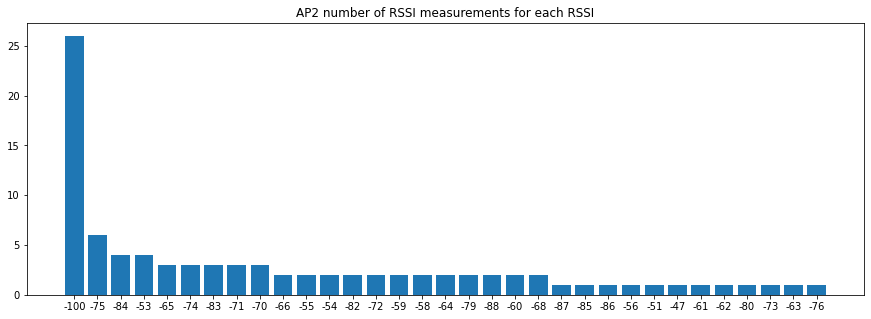

In [41]:
#Lets take a look at the measurement distribution
import matplotlib.pyplot as plt

counts = df_final['AP2'].value_counts()
plt.figure(figsize=(15,5))
plt.bar(counts.index, counts.values)
plt.title("AP2 number of RSSI measurements for each RSSI") 
plt.show()

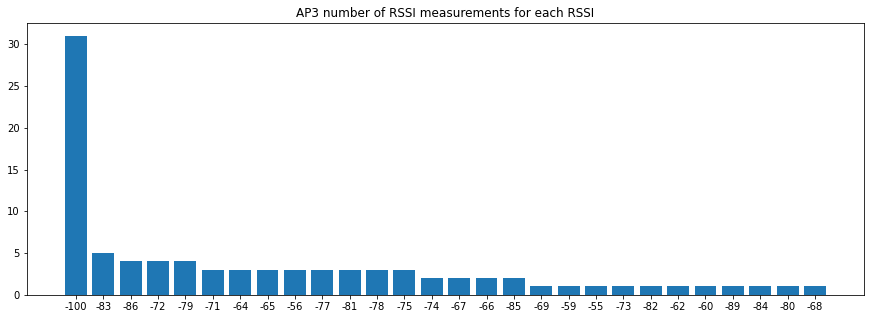

In [42]:
#Lets take a look at the measurement distribution
import matplotlib.pyplot as plt

counts = df_final['AP3'].value_counts()
plt.figure(figsize=(15,5))
plt.bar(counts.index, counts.values)
plt.title("AP3 number of RSSI measurements for each RSSI") 
plt.show()

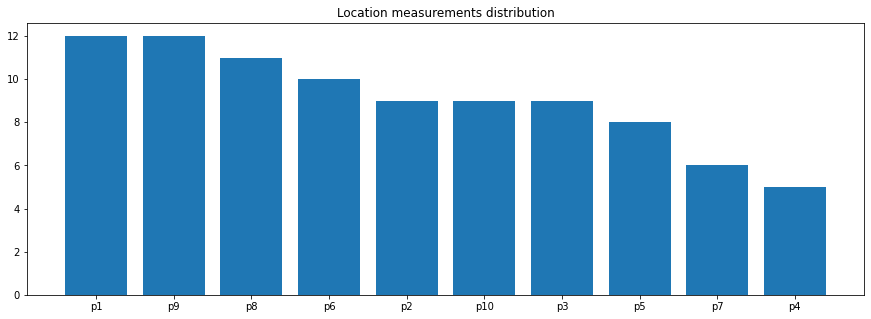

In [43]:
#Lets take a look at the measurement distribution
import matplotlib.pyplot as plt

counts = df_final['location'].value_counts()
plt.figure(figsize=(15,5))
plt.bar(counts.index, counts.values)
plt.title("Location measurements distribution") 
plt.show()

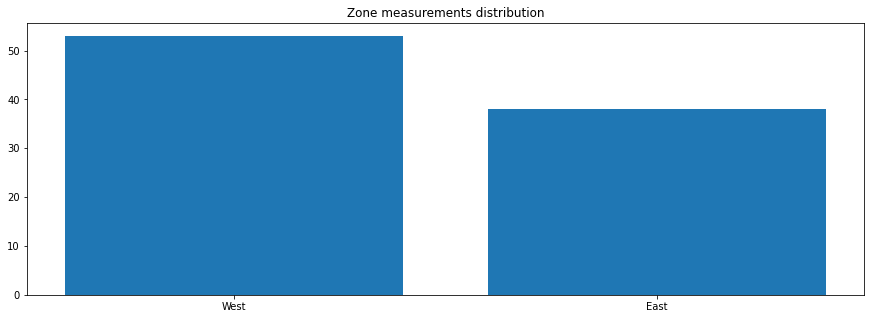

In [44]:
#Lets take a look at the measurement distribution
import matplotlib.pyplot as plt

counts = df_final['Zone'].value_counts()
plt.figure(figsize=(15,5))
plt.bar(counts.index, counts.values)
plt.title("Zone measurements distribution") 
plt.show()

### Let's separate the features and labels in separate dataframes

First we will play with the RSSI measurement and the label will be the zones (East or West)

In [45]:
#let's call X the array of features and y the arrays for labels
features = ["AP1","AP2","AP3"]

X = df_final[features]
X.head()

mrMac,AP1,AP2,AP3
time,,,
2022-05-17 01:06:00,-100,-66,-73
2022-05-17 01:06:00,-100,-62,-72
2022-05-17 01:07:00,-100,-64,-75
2022-05-17 01:07:00,-100,-61,-100
2022-05-17 01:08:00,-100,-65,-78


In [46]:
label = ['Zone']
y = df_final[label]
y.head()

mrMac,Zone
time,
2022-05-17 01:06:00,West
2022-05-17 01:06:00,West
2022-05-17 01:07:00,West
2022-05-17 01:07:00,West
2022-05-17 01:08:00,West


### Splitting the dataset in training and test

Before you can train your model, the last phase of the data manipulation is how you will split you data to train your model and after evaluate your model performance.

There are multiple ways of doing it and depending of your problem and model you can split it in different ways.

Since this is a first example, we will use a simple 70/30 split.

One very important consideration is to avoid data leaking between the groups of data used for train and test, otherwise you will be "cheating" and your model will be great when testing but won't work well when in production.

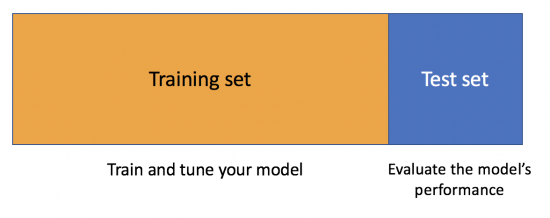

Source: https://docs.splunk.com/Documentation/ITSI/4.10.2/SI/TrainModel

In [47]:
#Let's use the sklearn module to do train test split for us.
#There are multiple option in this module that you can check at
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

p = 0.3 # percentage of elements used in the test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p)

In [48]:
#Lets check the shape of the data split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((63, 3), (28, 3), (63, 1), (28, 1))

In [49]:
X_train.head()

mrMac,AP1,AP2,AP3
time,,,
2022-05-17 02:03:00,-65,-100,-100
2022-05-17 02:02:00,-61,-100,-100
2022-05-17 01:34:00,-100,-100,-59
2022-05-17 02:01:00,-58,-100,-100
2022-05-17 01:03:00,-100,-65,-79


In [50]:
y_train.head()

mrMac,Zone
time,
2022-05-17 02:03:00,East
2022-05-17 02:02:00,East
2022-05-17 01:34:00,West
2022-05-17 02:01:00,East
2022-05-17 01:03:00,West


# **3. Train your Machine Learning Model**

Let's start with the **Decision Tree (DT)** model which permits easy understanding of the logic used by the model trained. It will be our baseline model.

Decision Tree Article: https://towardsdatascience.com/the-complete-guide-to-decision-trees-28a4e3c7be14


**Accuracy** will be the evaluation metric that we will use to compare the different models. <br><br>

Model accuracy is defined as the number of classifications a model **correctly predicts divided by the total number of predictions made**. It's a way of assessing the performance of a model, but certainly not the only way. <br><br>

We will also plot the **Confusion Matrix** to help our understanding of the model performance. This matrix presents the number of True Positives, True Negatives, False Positives and False Negatives.

## Training a Decision Tree Model

In [51]:
#sklearn - Simple and efficient tools for predictive data analysis · 
#Accessible to everybody, and reusable in various contexts · 
#Built on NumPy, SciPy, and matplotlib · Open

#Let's start with the sklearn DecisionTreeClassifier

from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### Training the model

In [52]:
# Decision Tree model
model_dt = DecisionTreeClassifier(
    criterion="gini", # used to measure the split quality
     max_depth=2, # used to define the maximum depth of the tree
    random_state=42 # seed to have always the same results
 )

# Building the model using the method fit
# Use the training dataset to build the model
model_dt.fit(
    X_train, # train examples with the features
    y_train # train examples with the class or target value
)


DecisionTreeClassifier(max_depth=2, random_state=42)

Gini impurity is a function that determines how well a decision tree was split. Basically, it helps us to determine which splitter is best so that we can build a pure decision tree. Gini impurity ranges values from 0 to 0.5.

### Understanding your model - visualizing the Decision Tree

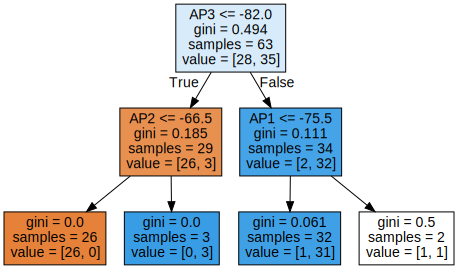

In [53]:
#Let's visualize the decision tree created by the model
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(model_dt,
                                feature_names=features,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [54]:
# Just to make it easier to understand the 63 samples
# considered are the entries of the train data, where 37 entries
# were West and 26 entries were East as we can visualize in the graph
y_train['Zone'].value_counts()


West    35
East    28
Name: Zone, dtype: int64

# **4. Test your model**

### Calculating the model "quality" using the accuracy metric and the confusion matrix

We are using accuracy as the initial metric, due to be more intuitive and easier to understand. However we need to consider it carefully, even in our example since we don't have a balanced number of entries for each class, and accuracy can be influenced by that. Other metrics could be used.

In [55]:
# Calculate the prediction based in the model trained
# generate the y_pred using the model and the test data
y_pred_dt = model_dt.predict(X_test)

#compare the predicted data with the test data to get how accurate the model is
acc = round(accuracy_score(y_test, y_pred_dt), 4)
print(f"Accuracy: {acc}")

Accuracy: 0.75


<AxesSubplot:>

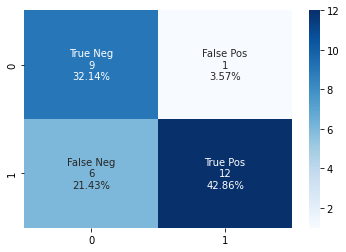

In [56]:
#Let's plot the confusion matrix to better understand the results of our model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import numpy as np

cm_dt = confusion_matrix(y_test, y_pred_dt)

cf_matrix = cm_dt


group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# **5. Improve your model**

### Estimating the contribution of each feature in the model

In [ ]:
# In decision tree models we can get the level of "importance" of each feature.
plt.barh(features, model_dt.feature_importances_)

When trying to improve the model efficiency, we can try to adjust the model hyperparameters, like the max deep of the DT, or we can try a different model. Based on the time we have today, the simulations with Random Forest won't be covered and are part of the bonus content, together with the multiclass classification.

# **Using Machine Learning model**

## Predicting the zone of a new device

Now we can use the model built using decision trees to predict the zone of a particular device, based in the RSSI levels observed by each AP.

In this first example we will use the following:

- AP1 RSSI of -17dBm
- AP2 RSSI of -34dBm
- AP3 RSSI of -67dBm

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Array with the features of this new event detected
new_event_features = [['-17', '-34', '-67']]

In [ ]:
#Necessary transformation to use it as an input to our model
new_event = np.array(new_event_features)
new_event.reshape(1, -1)
new_event.shape 

In [ ]:
#Let's use the model that we have trained
model_dt

In [ ]:
#We will use the method .predict to predict the class for this new example
new_event_pred = model_dt.predict(new_event)


In [ ]:
#Print the predicted value:
print('The client is located at', new_event_pred[0], 'Zone.')

## You can try now with your own data, using the model trained

In [ ]:
print('<<<<<<<<Start>>>>>>>>>')
AP1 = input("Enter the RSSI measured by AP1:")
AP2 = input("Enter the RSSI measured by AP2:")
AP3 = input("Enter the RSSI measured by AP3:")
print()
print('Thanks for the inputs! We are processing your request!')

#print(ssid_name,rogue_ssid,rogue_rssi,rogue_onwire)

In [ ]:
new_event_features = [[AP1, AP2, AP3]]
new_event = np.array(new_event_features)
new_event.reshape(1, -1)
new_event_pred = model_dt.predict(new_event)
print('The client is located at', new_event_pred[0], 'Zone.')



---



---



# **Bonus - RandomForest Model and Predicting the device location in areas (multiclass classification)**

## Bonus 1 - Training a Random Forest Model

In [ ]:
#sklearn - Simple and efficient tools for predictive data analysis · 
#Accessible to everybody, and reusable in various contexts · 
#Built on NumPy, SciPy, and matplotlib · Open

from sklearn.ensemble import RandomForestClassifier

### Training the model

In [ ]:
# Random Forest model

model_rf = RandomForestClassifier(
    criterion="gini", # used to measure the split quality
    max_depth=4, # used to define the maximum depth of the tree
    n_estimators=30, # número de árvores
    #class_weight="balanced", # atribuir o mesmo peso para as duas classes
    random_state=42 # seed to have always the same results
 )

# Building the model using the method fit
# Use the training dataset to build the model
model_rf.fit(
    X_train, # train examples with the features
    y_train # train examples with the class or target value
)


### Calculating the model "quality" using the accuracy metric and the confusion matrix

In [ ]:
# prediction based in the model trained
# generate the y_pred using the model and the test data
y_pred_rf = model_rf.predict(X_test)

#compare the predicted data with the test data to get how accurate the model is
acc = round(accuracy_score(y_test, y_pred_rf), 4)
print(f"Accuracy: {acc}")

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

cm_rf = confusion_matrix(y_test, y_pred_rf)

cf_matrix = cm_rf

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### Understanding your model - visualizing the Random Forest

In [ ]:
#Trees generated, selecting one to be plotted
len(model_rf.estimators_)

In [ ]:
#Select tree 4 model
estimator = model_rf.estimators_[4]
estimator

In [ ]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(estimator,
                                feature_names=features,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

## Bonus 2 - Multiclass Classification - predicting the Areas, instead of just Zones East or West.

Besides of doing just East or West zone we could also try a more granular classification, based on the Areas of the building, like the next image. For that we need to add an extra column with the areas that we will use as the new labels.

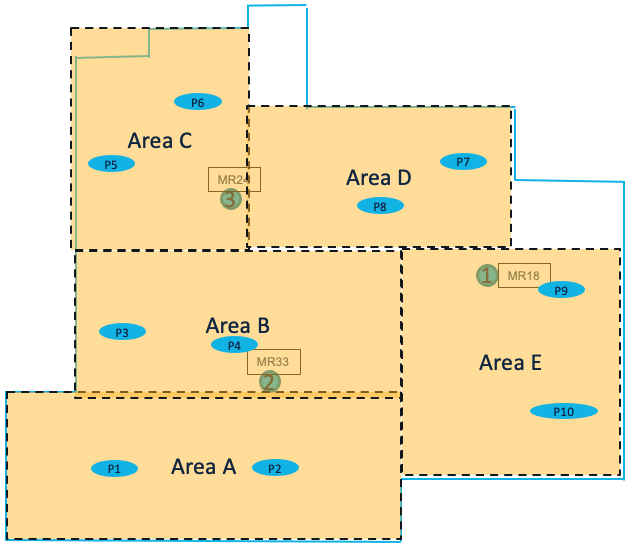

In [ ]:
#Add a new column called Zone based on the positions
df_final.loc[df_final['location']=='p1','Area'] = 'A'
df_final.loc[df_final['location']=='p2','Area'] = 'A'
df_final.loc[df_final['location']=='p3','Area'] = 'B'
df_final.loc[df_final['location']=='p4','Area'] = 'B'
df_final.loc[df_final['location']=='p5','Area'] = 'C'
df_final.loc[df_final['location']=='p6','Area'] = 'C'
df_final.loc[df_final['location']=='p7','Area'] = 'D'
df_final.loc[df_final['location']=='p8','Area'] = 'D'
df_final.loc[df_final['location']=='p9','Area'] = 'E'
df_final.loc[df_final['location']=='p10','Area'] = 'E'

In [ ]:
#Lets take a look at the measurement distribution
import matplotlib.pyplot as plt

counts = df_final['Area'].value_counts()
plt.figure(figsize=(15,5))
plt.bar(counts.index, counts.values)
plt.title("Area measurements distribution") 
plt.show()

In [ ]:
#let's call X the array of features and y the arrays for labels
features = ["AP1","AP2","AP3"]

X = df_final[features]
X.head()

In [ ]:
label = ['Area']
y = df_final[label]
y.head()

In [ ]:
from sklearn.model_selection import train_test_split

p = 0.3 # percentage of elements used in the test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# Random Forest model

model_rf = RandomForestClassifier(
    criterion="gini", # used to measure the split quality
    max_depth=5, # used to define the maximum depth of the tree
    n_estimators=100, # número de árvores
    #class_weight="balanced", # atribuir o mesmo peso para as duas classes
    random_state=42 # seed to have always the same results
 )

# Building the model using the method fit
# Use the training dataset to build the model
model_rf.fit(
    X_train, # train examples with the features
    y_train # train examples with the class or target value
)


In [ ]:
# prediction based in the model trained
# generate the y_pred using the model and the test data
y_pred_rf = model_rf.predict(X_test)

#compare the predicted data with the test data to get how accurate the model is
acc = round(accuracy_score(y_test, y_pred_rf), 4)
print(f"Accuracy: {acc}")

In [ ]:
#Plotting the confusion matrix

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8,8))
sns.heatmap(cm_rf, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
#Select tree 4 model
estimator = model_rf.estimators_[4]
estimator

In [ ]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(estimator,
                                feature_names=features,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph



---



---



# **Next Steps**

## **This is just the beginning!! Today we have limited time but here you have more ideas to explore!**

There are many more possible examples about how you can start using ML in your Wi-Fi projects and operations.

Here are some other examples that we won't have time to go over today together!

### **Regression Example**

Using regression instead of classification, we can calculate a value based in the features of the examples collected.

Also in this case, instead of looking the number of False Positives and False Negatives, we compute the loss function of the data points versus the value predicted by model.



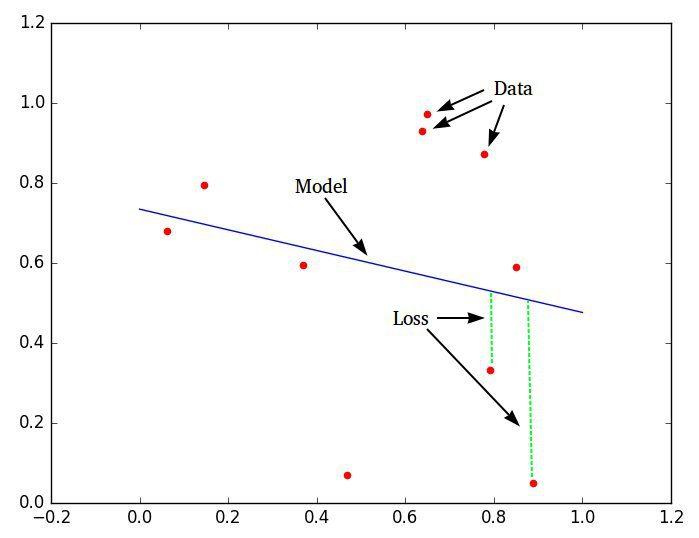

Image Source:https://www.kdnuggets.com/2017/06/regression-analysis-really-machine-learning.html 

This could be used in a lot of different scenarios like:

- We can use **Wi-Fi and/or BLE RSSI measurements to build our on location algorithm based in the fingerprints** collected.

- Predict the **Throughput of a client based in observations made in the network looking RSSI, SNR, Tput of the client, together with AP data like number of clients, channel width, channel utilization** and many others.


### **Time Series Forecasting**

When you have data that the sequence of it matters in the problem that you are trying to solve, you need to use a special approach that considers your data a time series type.


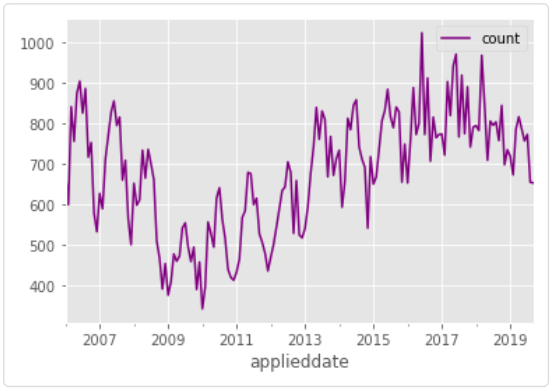

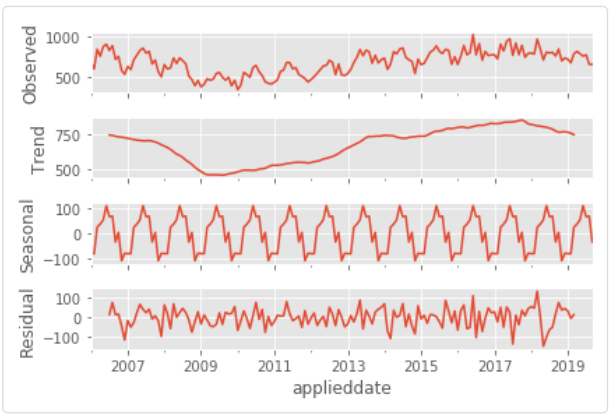

Image Source: https://dev.socrata.com/blog/2019/10/07/time-series-analysis-with-jupyter-notebooks-and-socrata.html


We have a lot of different use cases for time series analysis, and this also applies to Wi-Fi related scenarios.

Here are some examples:


- Try to **predict the number of employees that will be in the office** based in the measurements that we are getting in the last days and weeks. The sazonality of the data is key to predict it since people may avoid to go to the office on Mondays and Fridays.

- Use channel plan information colleted during the days and weeks, to **suggest a channel change or a different channel plan** based in previous observations. Channels can change depending of interferers that may show up during the day.


# **I hope you enjoyed and will have fun combining Wi-Fi and ML!**

# **Thanks for coming!**